# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [127]:
# import libraries

import numpy as np
import pandas as pd

from pyspark.sql import SparkSession, Window

#from pyspark.sql.functions import udf, sum as Fsum, desc, asc, countDistinct, col, to_date, year, month, dayofmonth, minute, hour, datediff, min, max, isnull, when
import pyspark.sql.functions as F

from pyspark.sql.types import IntegerType, DateType, TimestampType, StringType, DoubleType, LongType

%matplotlib inline
import matplotlib.pyplot as plt

import datetime

from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml import Pipeline

from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.classification import LogisticRegression

# for model evaluation
from sklearn.metrics import f1_score, recall_score, precision_score

# for Principal Component Analysis
from pyspark.ml.feature import PCA


In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

In [3]:
# Install additional libraries via pip in the current Jupyter kernel
import sys
!{sys.executable} -m pip install pixiedust

    100% |████████████████████████████████| 204kB 2.2MB/s ta 0:00:01
    100% |████████████████████████████████| 798kB 3.4MB/s ta 0:00:01
  Running setup.py bdist_wheel for pixiedust ... done
  Stored in directory: /root/.cache/pip/wheels/25/fa/a5/09c1e8f4c91b34c5f7f4ac6e41be81dd0667030a2372546a8d
  Running setup.py bdist_wheel for mpld3 ... done
  Stored in directory: /root/.cache/pip/wheels/c0/47/fb/8a64f89aecfe0059830479308ad42d62e898a3e3cefdf6ba28
Successfully built pixiedust mpld3


In [4]:
import pixiedust

Pixiedust database opened successfully
Table VERSION_TRACKER created successfully
Table METRICS_TRACKER created successfully

Share anonymous install statistics? (opt-out instructions)

PixieDust will record metadata on its environment the next time the package is installed or updated. The data is anonymized and aggregated to help plan for future releases, and records only the following values:

{
   "data_sent": currentDate,
   "runtime": "python",
   "application_version": currentPixiedustVersion,
   "space_id": nonIdentifyingUniqueId,
   "config": {
       "repository_id": "https://github.com/ibm-watson-data-lab/pixiedust",
       "target_runtimes": ["Data Science Experience"],
       "event_id": "web",
       "event_organizer": "dev-journeys"
   }
}
You can opt out by calling pixiedust.optOut() in a new cell.


Pixiedust runtime updated. Please restart kernel
Table SPARK_PACKAGES created successfully
Table USER_PREFERENCES created successfully
Table service_connections created successfully


In [5]:
pixiedust.optOut()

Pixiedust will not collect anonymous install statistics.


# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [6]:
path = "mini_sparkify_event_data.json"
user_log = spark.read.json(path)

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

#### Exploratory Data Analysis

In [7]:
display(user_log)

In [8]:
for column in user_log.columns:
    print("Analysis of column {}".format(column))
    print("Statistical properties:")
    print(user_log.describe(column).show())
    print("\nCount of unique values in column:")
    print(user_log.select(F.countDistinct(column)).show(),"\n")

Analysis of column artist
Statistical properties:
+-------+------------------+
|summary|            artist|
+-------+------------------+
|  count|            228108|
|   mean| 551.0852017937219|
| stddev|1217.7693079161374|
|    min|               !!!|
|    max| ÃÂlafur Arnalds|
+-------+------------------+

None

Count of unique values in column:
+----------------------+
|count(DISTINCT artist)|
+----------------------+
|                 17655|
+----------------------+

None 

Analysis of column auth
Statistical properties:
+-------+----------+
|summary|      auth|
+-------+----------+
|  count|    286500|
|   mean|      null|
| stddev|      null|
|    min| Cancelled|
|    max|Logged Out|
+-------+----------+

None

Count of unique values in column:
+--------------------+
|count(DISTINCT auth)|
+--------------------+
|                   4|
+--------------------+

None 

Analysis of column firstName
Statistical properties:
+-------+---------+
|summary|firstName|
+-------+---------+
|

In [9]:
# further analysis of relationship between page and status...
user_log.groupBy(["status", "method", "page"]).count().orderBy("status", "method", "count").show()

+------+------+--------------------+------+
|status|method|                page| count|
+------+------+--------------------+------+
|   200|   GET|            Register|    18|
|   200|   GET|Cancellation Conf...|    52|
|   200|   GET|             Upgrade|   499|
|   200|   GET|               About|   924|
|   200|   GET|            Settings|  1514|
|   200|   GET|                Help|  1726|
|   200|   GET|           Downgrade|  2055|
|   200|   GET|         Roll Advert|  3933|
|   200|   GET|                Home| 14457|
|   200|   PUT|     Add to Playlist|  6526|
|   200|   PUT|            NextSong|228108|
|   307|   PUT| Submit Registration|     5|
|   307|   PUT|              Cancel|    52|
|   307|   PUT|    Submit Downgrade|    63|
|   307|   PUT|      Submit Upgrade|   159|
|   307|   PUT|       Save Settings|   310|
|   307|   PUT|         Thumbs Down|  2546|
|   307|   PUT|              Logout|  3226|
|   307|   PUT|               Login|  3241|
|   307|   PUT|          Add Fri

In [10]:
# detailled analysis of feature "userAgent"
pd_df = user_log.groupBy("userAgent").count().orderBy("count").toPandas()
print(pd_df["userAgent"].tolist())
pd_df["count"].describe()

['Mozilla/5.0 (X11; Ubuntu; Linux i686; rv:31.0) Gecko/20100101 Firefox/31.0', '"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_8) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', '"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.94 Safari/537.36"', '"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.6; rv:31.0) Gecko/20100101 Firefox/31.0', '"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_7_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', '"Mozilla/5.0 (Windows NT 6.2; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', '"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_2) AppleWebKit/537.75.14 (KHTML, like Gecko) Version/7.0.3 Safari/537.75.14"', '"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_7_5) AppleWebKit/537.77.4 (KHTML, like Gecko) Ver

count       57.000000
mean      5026.315789
std       5570.658201
min         62.000000
25%       1262.000000
50%       2544.000000
75%       7624.000000
max      22751.000000
Name: count, dtype: float64

### Findings of descriptive statistics on data sample per feature: ###
* Summary per feature:
    * auth: no missing values; 4 distinct values. 
        * follow-up: check if missing values relate to value "Logged Out"
    * artist: few missing values; 17655 distinct values.
    * song: few missing values; 58480 distinct values.
    * userID: no missing values; 226 distinct values.
    * firstName: few missing values; 189 distinct values.
    * LastName: few missing values; 173 distinct values.
    * gender: few missing values; 2 distinct values.
    * ItemInSession: no missing values; 1322 distinct values.
        * follow-up: analyse meaning on example of one user
    * length: few missing values; 14865 distinct values.
        * follow-up: analyse meaning on example of one user
    * level: no missing values; 2 distinct values.
    * location: few missing values; 114 distinct values
        * follow-up: analyse user locations according to Country, State, etc
    * method: no missing values; 2 distinct values.
        * follow-up: analyse meaning on example of one user
    * page: no missing values; 22 distinct values.
    * registration: few missing values; 225 distinct values.
        * relates to 226 unique userID's minus empty name
        * format equals timestamp -> follow-up: convert to time/date
    * sessionID: few missing values; 2354 distinct values.
        * follow-up: analyse meaning on example of one user
    * status: no missing values; 3 distinct values.
    * ts: no missing values; 277447 unique values.
        * follow-up: conversion to date/ time
        * follow-up: analyse spread of date/ time
        * follow-up: further conversion to features for year/ month/ time
    * userAgent: few missing values; 56 distinct values
        * follow-up: further analyse values and value distribution

* Follow-up summary:
    1. "auth": check if missing values relate to value "Logged Out"
    2. analyse meaning on example of one user:
        * list = ["ItemInSession", "length", "method", "sessionID"]
    3. print categorical features with low cardinality (less than 56 distinct values):
        * list = ["auth", "gender", "level", "method", "page", "status", "userAgent"]
        * value name and value counts
    4. "location": analyse user locations and CSA (Combined Statistical Areas)
    * convert to time/date via new feature:
        * list = ["registration", "ts"]
    5. "ts": analyse spread of date/ time
    6. "ts": further conversion to features for year/ month/ time

#### Findings on (1):
* "auth" value "Cancelled" correlates to "page" value "Cancellation Confirmed".
* "auth" value "Guest" does not have any relevant information on users and can for churn use case be dropped.
    * follow-up: drop corresponding rows (user_log["auth"]=="Guest")
* "auth" value "Logged Out" does not have any relevant information on users and can for churn use case be dropped.
    * follow-up: drop corresponding rows (user_log["auth"]==""Logged Out"") 
* "auth" values "Logged In" has no missing artist values at page value "NextSong" (ca  72% in sample data set).
    * interpretation: users are in this cases listenting to music.
* "auth" values "Logged In" has missing artist values at all other pages (ca 18%in sample data set).
    * interpretation: users are in this cases not listenting to music, but doing other transactions

#### (2) analyse meaning on example of one user: ####
list = ["ItemInSession", "length", "method", "sessionID"]

Findings:
* number of items per "sessionId" does not equal values in "ItemInSession"
* "method" appear to refer to user interaction. Interpretation:
    * PUT: action by user. Therefore PUT data should be furhter analyzed.
    * GET: reaction to user
* "lenght" refers to song length
* "sessionID": values are not unique. 
    * Several users can share the same session Id.
    * an examplary analysis showed not direct relation between users that share the same sessionId

#### Findings on (3) ####
* "status": refers to html status codes (https://en.wikipedia.org/wiki/List_of_HTTP_status_codes)
    * 200: page ok
    * 307: Temporary redirect
    * 404: error
* "userAgent": needs to be split up into further features for analysis, e.g. influence of operating system

#### (4) "location": analyse user locations and CSA (Combined Statistical Areas)

In [11]:
# create new feature CSA (Combined Statistical Areas) from location 
get_csa = F.split(user_log["location"], ", ")
user_log = user_log.withColumn("CSA", get_csa.getItem(1))

In [12]:
distinct_users_csa = user_log.select("userId", "CSA").distinct().count()
distinct_users_location = user_log.select("userId", "location").distinct().count()
print("Distinct users per CSA: {}. Distinct users per location: {}".format(distinct_users_csa, distinct_users_location))

Distinct users per CSA: 226. Distinct users per location: 226


####  (5) convert to time/date: ####
list = ["registration", "ts"]

In [13]:
def convert_ts_to_datetime(df, column):
    get_datetime = F.udf(lambda timestamp: datetime.datetime.fromtimestamp(timestamp/1000).isoformat())
    df = df.withColumn(column + "_ts", get_datetime(df[column]).cast(TimestampType()))
    return df

In [14]:
# create new features in timestamp format from features "registration", "ts"
#column_list = ["registration", "ts"]
user_log = convert_ts_to_datetime(user_log, "ts")

#### (6) "ts": analyse spread of date/ time

In [15]:
min_date, max_date = user_log.select(F.min("ts_ts"), F.max("ts_ts")).first()
print("Minimum and Maximum timestamp data:")
min_date, max_date

Minimum and Maximum timestamp data:


(datetime.datetime(2018, 10, 1, 0, 1, 57),
 datetime.datetime(2018, 12, 3, 1, 11, 16))

#### (7) "ts": further conversion to features for date/ hour

In [16]:
# get new features day and hour
user_log = user_log.withColumn("ts_hour", F.hour("ts_ts"))
user_log = user_log.withColumn("ts_date", F.to_date("ts_ts"))

Analyze log data over time:


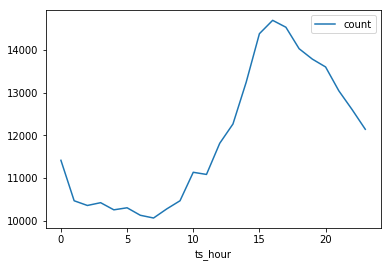

In [17]:
print("Analyze log data over time:")
#pd_df = user_log.select(hour("ts_ts").alias("hour")).groupBy("hour").count().orderBy("hour").toPandas()
pd_df = user_log.select("ts_hour").groupBy("ts_hour").count().orderBy("ts_hour").toPandas()
pd_df.plot.line(x="ts_hour", y="count");

## Features from "page" value ##

### Selection of page values for new features:
* "downgraded" from "Submit Downgrad"
* ...

In [19]:
def create_page_value_feature(df, page_value, col_name):
    '''
    ARGS:
    OUTPUT
    
    Function that creates a new feature from a certain value of feature "page"
    '''
    flag_page_value_event = F.udf(lambda page: 1 if page == page_value else 0, IntegerType())
    return df.withColumn(col_name, flag_page_value_event("page"))

In [20]:
page_value_feature_dict = {"Submit Downgrade" : "downgraded",
                           "Submit Upgrade" : "upgraded",
                           "Roll Advert" : "advert_shown",
                           "Thumbs Down": "thumps_down",
                           "Thumbs Up": "thumps_up",
                           "Add Friend": "friend_added",
                           "Add to Playlist" : "song_added"
                          }

for page_value in page_value_feature_dict.keys():
    column_name = page_value_feature_dict[page_value]
    user_log =  create_page_value_feature(user_log, page_value, column_name)

## Define feature "churn"

In [24]:
flag_churn_event = F.udf(lambda page: 1 if page == "Cancel" else 0, IntegerType())
user_log = user_log.withColumn("churn", flag_churn_event("page"))

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

## Explore data with regards to churn

In [46]:
all_users_count = user_log.select("userId").filter(user_log["userId"]!="").distinct().count()
churned_users_count = user_log.select("userId").filter(user_log["churn"]==1).distinct().count()
print("Out of a total {} users, {} users churned. These are {:.1f} %".format(
all_users_count, churned_users_count, churned_users_count*100/all_users_count))

Out of a total 225 users, 52 users churned. These are 23.1 %


## Create new dataframe for features bases on userId's

In [45]:
# create new df for features
all_users_collect = user_log.select("userId").filter(user_log["userId"]!="").distinct().collect()
all_users = set([int(row["userId"]) for row in all_users_collect])
features_df = spark.createDataFrame(all_users, IntegerType()).withColumnRenamed('value', 'userId')

## Encode label "churned users"

In [48]:
# create feature "label" for churned users
churned_users_collect = user_log.select("userId").filter(user_log["churn"]==1).collect()
churned_users = set([int(row["userId"]) for row in churned_users_collect])
get_churn = F.udf(lambda user: 1 if user in churned_users else 0, IntegerType())
features_df = features_df.withColumn("label", get_churn("userId"))

## Encode features "gender", "level"

### Encode "gender"
* gender value "M" = value 1
* gender value "F" = value 0

In [49]:
# one hot encode gender in original df
one_hot_encode_gender = F.udf(lambda gender: 1 if gender == "M" else 0, IntegerType())
user_log = user_log.withColumn("gender_bin", one_hot_encode_gender("gender"))

In [50]:
# join binary gender on userId in features df
user_gender_selection =  user_log.select(["userId", "gender_bin"]).dropDuplicates(subset=['userId'])
features_df = features_df.join(user_gender_selection, "userId")

### Encode "level"
* level value "paid" = value 1
* level value "free" = value 0

In [51]:
# one hot encode level in original df
one_hot_encode_level = F.udf(lambda level: 1 if level == "paid" else 0, IntegerType())
user_log = user_log.withColumn("level_bin", one_hot_encode_level("level"))

In [52]:
# join binary gender on userId in features df
user_level_selection =  user_log.select(["userId", "level_bin"]).dropDuplicates(subset=['userId'])
features_df = features_df.join(user_level_selection, "userId")

## Encode page view features
* encode count of page view features per userId
* page view features to be included: 
['downgraded',
 'upgraded',
 'advert_shown',
 'thumps_down',
 'thumps_up',
 'friend_added',
 'song_added']

In [53]:
page_features_count = user_log.groupBy("userId").sum('downgraded', 'upgraded',
 'advert_shown',
 'thumps_down',
 'thumps_up',
 'friend_added',
 'song_added')
features_df = features_df.join(page_features_count, "userId", how="left")

## Encode further features - tbd +++++++++++++
* "song_count": songs per user
* "days_since_reg": days from registration until latest user timestamp of a user

In [69]:
user_log.schema.names

['artist',
 'auth',
 'firstName',
 'gender',
 'itemInSession',
 'lastName',
 'length',
 'level',
 'location',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userAgent',
 'userId',
 'CSA',
 'ts_ts',
 'ts_hour',
 'ts_date',
 'downgraded',
 'upgraded',
 'advert_shown',
 'thumps_down',
 'thumps_up',
 'friend_added',
 'song_added',
 'churn',
 'gender_bin',
 'level_bin']

In [73]:
# create new feature "song_count" in features_df
song_count = user_log.groupBy("userId").agg(F.count("song").alias("song_count")).orderBy("song_count", ascending=False)
features_df = features_df.join(song_count, "userId", how="left")

In [96]:
# create new feature "days_since_reg" in features_df

# create new features in timestamp format from features "registration"
reg_df=user_log.select("userId", "registration").filter(user_log["registration"].isNotNull()).distinct()
reg_df = convert_ts_to_datetime(reg_df, "registration")
reg_df = reg_df.withColumn("reg_date", F.to_date("registration_ts"))

# calculate difference between last user timestamp date and registration date
last_user_ts = user_log.groupBy("userId").agg(F.max("ts_date").alias("last_user_ts_date"))
reg_df = reg_df.join(last_user_ts, "userId", how="left")
reg_df = reg_df.withColumn("days_since_reg", F.datediff("last_user_ts_date", "reg_date"))

# add feature "days_since_reg" to features_df
features_df = features_df.join(reg_df.select("userId", "days_since_reg"), "userId", how="left")

In [132]:
# get new feature for accumulated session time per userId

user_session_min_ts = user_log.groupBy("userId", "sessionID").agg(F.min("ts")).orderBy("userId", "sessionID")
user_session_max_ts = user_log.groupBy("userId", "sessionID").agg(F.max("ts")).orderBy("userId", "sessionID")
user_session_max_ts = user_session_max_ts.join(user_session_min_ts, ["userId", "sessionID"])
user_session_max_ts = user_session_max_ts.withColumn("session_time_seconds", ((user_session_max_ts["max(ts)"]-user_session_max_ts["min(ts)"])/1000).cast(LongType()))

# calculate total session time per user
total_user_session_time = user_session_max_ts.groupBy("userId").agg(F.sum("session_time_seconds").alias("total_session_time_sec"))

# add feature "session_time_seconds" to features_df
features_df = features_df.join(total_user_session_time, "userId", how="left")

# Feature selection

In [133]:
display(features_df)

## Feature scaling and vectorization

In [124]:
features_df.schema.names

['userId',
 'label',
 'gender_bin',
 'level_bin',
 'sum(downgraded)',
 'sum(upgraded)',
 'sum(advert_shown)',
 'sum(thumps_down)',
 'sum(thumps_up)',
 'sum(friend_added)',
 'sum(song_added)',
 'sum(downgraded)_scaled',
 'sum(upgraded)_scaled',
 'sum(advert_shown)_scaled',
 'sum(thumps_down)_scaled',
 'sum(thumps_up)_scaled',
 'sum(friend_added)_scaled',
 'sum(song_added)_scaled',
 'features',
 'song_count',
 'days_since_reg',
 'total_session_time_sec']

### Vectorize and scale non-binary features
* Vectorization via VectorAssembler
* Scaling via MinMaxScaler
* user Pipeline to combine both in the transformation process

In [131]:
nonbinary_feature_list = [
 'sum(downgraded)',
 'sum(upgraded)',
 'sum(advert_shown)',
 'sum(thumps_down)',
 'sum(thumps_up)',
 'sum(friend_added)',
 'sum(song_added)',
 'song_count',
 'days_since_reg',
 'total_session_time_sec']

In [56]:
convert_vector_to_double = F.udf(lambda vector_value: round(float(list(vector_value)[0]),3), DoubleType())


for column in nonbinary_feature_list:
    # convert column to vector via VectorAssembler
    assembler = VectorAssembler(inputCols=[column], outputCol=column+"_vect")
    # Scale vectorized column
    scaler = MinMaxScaler(inputCol=column+"_vect", outputCol=column+"_scaled")
    # create Pipeline with assembler and scaler
    pipeline = Pipeline(stages=[assembler, scaler])
    # apply pipelien on features_df Dataframe
    features_df = pipeline.fit(features_df).transform(features_df) \
    .withColumn(column+"_scaled", convert_vector_to_double(column+"_scaled")).drop(column+"_vect")

In [ ]:
features_df.printSchema()

### Merge scaled features to one feature vector

In [57]:
# create feature list that shall be merged in on vector
feature_list = features_df.schema.names
# remove columns userId, label and all items in nonbinary_feature_list
remove_features_list= nonbinary_feature_list + ["userId", "label"]
feature_list = [item for item in feature_list if item not in remove_features_list]
# assemble features in feature_list to one vector using VectorAssembler
assembler = VectorAssembler(inputCols=feature_list, outputCol="features")
features_df = assembler.transform(features_df)

In [ ]:
features_df.printSchema()

## Perform PCA to select relevant features

In [ ]:
pca = PCA(k=5, inputCol="features", outputCol="pcaFeatures")
model = pca.fit(features_df["features"])

result = model.transform(features_df["features"]).select("pcaFeatures")
result.show(truncate=False)

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

## Split in training, test, validation set

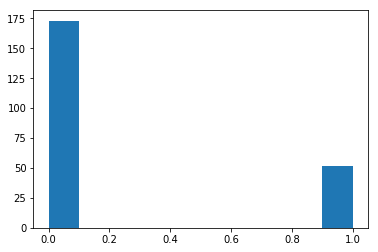

In [58]:
train, test = features_df.randomSplit([0.8, 0.2], seed=42)

plt.hist(features_df.toPandas()['label'])
plt.show()

### Analyze label class imbalance - tbd +++++++++++++

In [60]:
# calculate balancing ratio for account for class imbalance

balancing_ratio = train.filter(train['label']==0).count()/train.count()
train=train.withColumn("classWeights", F.when(train.label == 1,balancing_ratio).otherwise(1-balancing_ratio))

## Machine Learning Model Selection, Tuning and Evaluation
 * Model learning problem category: supervised learning, logistic regression
 * ML estimators from pyspark.ml:
     * LogisticRegression
     * tbd
 * ML hyperparameters in estimators (for grid search/ tuning):
     * LogisticRegression(maxIter=10, regParam=0.0, elasticNetParam=0)
     * tbd
 * ML evaluators from pyspark.ml:
     * BinaryClassificationEvaluator
     * tbd

In [61]:
# Create a logistic regression object
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', weightCol="classWeights")

# create evaluator
evaluator = BinaryClassificationEvaluator(metricName = 'areaUnderPR')


In [62]:
# create lr_model
lr_model = lr.fit(train)
training_summary = lr_model.summary

In [ ]:
# ToDo: evaluate training summary ++++++++++++++++

# TBD

## Tune Model
* use cross validation via CrossValidator and paramGrid

In [63]:
# build paramGrid and cross validator
paramGrid = (ParamGridBuilder() \
    .addGrid(lr.maxIter, [1, 5, 10]) \
    .addGrid(lr.regParam,[0.01, 0.1, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build())


crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

In [64]:
# run cross validation
# train model on train data
crossval_model = crossval.fit(train)
# predict on test data
pred = crossval_model.transform(test)

In [ ]:
#cvModel_q1 = crossval.fit(training)

In [ ]:
#cvModel_q1.avgMetrics

In [ ]:
#results = cvModel_q1.transform(test)

## Evaluate results
* use scikit learn metrics f1, precision, recall for model evaluation

In [65]:
# evaluate results
pd_pred = pred.toPandas()

In [66]:
pd_pred.head()

,userId,label,gender_bin,level_bin,sum(downgraded),sum(upgraded),sum(advert_shown),sum(thumps_down),sum(thumps_up),sum(friend_added),...,sum(upgraded)_scaled,sum(advert_shown)_scaled,sum(thumps_down)_scaled,sum(thumps_up)_scaled,sum(friend_added)_scaled,sum(song_added)_scaled,features,rawPrediction,probability,prediction
0,137,0,1,0,0,1,10,1,8,8,...,0.25,0.078,0.013,0.018,0.056,0.017,"[1.0, 0.0, 0.0, 0.25, 0.078, 0.013, 0.018, 0.0...","[-0.582222225032, 0.582222225032]","[0.358421420169, 0.641578579831]",1.0
1,65,0,1,0,0,1,8,17,111,53,...,0.25,0.062,0.227,0.254,0.371,0.283,"[1.0, 0.0, 0.0, 0.25, 0.062, 0.227, 0.254, 0.3...","[0.896119455314, -0.896119455314]","[0.710151397173, 0.289848602827]",0.0
2,133,0,1,0,0,0,1,0,2,1,...,0.00,0.008,0.000,0.005,0.007,0.013,"[1.0, 0.0, 0.0, 0.0, 0.008, 0.0, 0.005, 0.007,...","[-0.48276677666, 0.48276677666]","[0.381599004404, 0.618400995596]",1.0
3,78,0,0,0,0,0,16,3,11,2,...,0.00,0.125,0.040,0.025,0.014,0.037,"[0.0, 0.0, 0.0, 0.0, 0.125, 0.04, 0.025, 0.014...","[-0.261030769771, 0.261030769771]","[0.435110339059, 0.564889660941]",1.0
4,76,0,1,0,0,0,15,2,13,3,...,0.00,0.117,0.027,0.030,0.021,0.017,"[1.0, 0.0, 0.0, 0.0, 0.117, 0.027, 0.03, 0.021...","[-0.569896815398, 0.569896815398]","[0.361260634501, 0.638739365499]",1.0


In [67]:
# calculate score for f1, precision, recall
f1 = f1_score(pd_pred.label, pd_pred.prediction)
recall = recall_score(pd_pred.label, pd_pred.prediction)
precision = precision_score(pd_pred.label, pd_pred.prediction)

In [68]:
print("F1 Score: {:.2f}, Recall: {:.2f}, Precision: {:.2f}".format(f1, recall, precision))

F1 Score: 0.29, Recall: 0.40, Precision: 0.22


In [ ]:
# TODO: change label or create feature label

#correct_results = (results.filter(results.label == results.prediction).count())
#total_results= (results.count())
#accuracy = correct_results/ total_results

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.